In [41]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



In [42]:
raw = pd.read_excel('raw data for Andres - Morona BMAP.xlsx', sheet_name = 'Composition')
raw['Date'] = pd.to_datetime(raw['Date'], errors='coerce')
raw = raw.sort_values(['Phase #','Date'])
raw["SVL (mm)"] = raw["SVL (mm)"].replace(['na'],[0])

In [43]:
op = pd.read_excel(open('op data anal - Morona BMAP.xlsx', 'rb'), usecols = "A:H", header = 1, sheet_name = 'subset summary')
bio = pd.read_excel(open('raw data for Andres - Morona BMAP.xlsx', 'rb'), header = 0, sheet_name = 'Composition')

# Import variable translation csv
variable_data = pd.read_csv('Variable_translate.csv', header = None, encoding = 'unicode_escape')    

# Tranfrom csv to dictionary
trans_dict = variable_data.set_index(0).T.to_dict('index')[1]

# Translate column names to English
bio = bio.rename(columns = trans_dict)
#bio_raw.to_csv('cleaned raw data.csv')

In [44]:
op["Date"] = pd.to_datetime(op["Date"])
bio["Date"] = pd.to_datetime(bio["Date"])
#op_raw.sort_values(['Date'])
#bio_raw.set_index('Date').join(op_raw.set_index('Date')) #, how = 'inner')
#bio.loc[bio.Date== '2014-06-23',:]

In [45]:
subbio = bio.loc[:, ["Phase", "Date", "Family", "Genus", "Species"]]
for i in subbio.Family.unique():
    op[i] = np.nan
op['Observations'] = np.nan

In [46]:
bio_date = subbio.Date.unique()
op_date = op.Date.unique()
for i in bio_date:
    if i in op_date:
        temp = subbio.loc[subbio.Date == i, :]
        op.loc[op['Date'] == i, ['Observations']] = len(temp)
        
        family = temp.Family.value_counts()
        for j in family.index.tolist():
            op.loc[op['Date'] == i, j] = family[j]



In [47]:
op.describe()

,S_peeps,S_hour,OPE,Rain,S_fuel,flights,Craugastoridae,Bufonidae,Plethodontidae,Hylidae,Leptodactylidae,Phyllomedusidae,Centrolenidae,Rhinathrematidae,Observations
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,43.000000,41.000000,5.000000,17.000000,18.000000,5.000000,7.000000,2.0,45.000000
mean,104.341880,1282.461538,7.598291,1.439316,261.632479,8.803419,9.674419,3.707317,1.200000,2.235294,2.000000,1.200000,1.428571,1.0,14.800000
std,52.535401,598.086814,4.508727,2.645848,272.349408,9.107821,4.853673,2.812862,0.447214,1.393261,1.236694,0.447214,0.534522,0.0,7.313126
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,3.000000
25%,70.000000,920.000000,5.000000,0.000000,0.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,10.000000
50%,103.000000,1190.000000,6.000000,0.000000,170.000000,6.000000,9.000000,3.000000,1.000000,2.000000,1.500000,1.000000,1.000000,1.0,13.000000
75%,125.000000,1450.000000,9.000000,1.500000,454.000000,12.000000,12.500000,6.000000,1.000000,4.000000,2.750000,1.000000,2.000000,1.0,19.000000
max,214.000000,2390.000000,15.000000,11.000000,1400.000000,39.000000,21.000000,11.000000,2.000000,5.000000,4.000000,2.000000,2.000000,1.0,30.000000


In [56]:
op['size'] = ['L' if x >= 14 else 'S' for x in op['Observations']]
op['label'] = ['F' if str(x) == 'nan' else 'T' for x in op['Observations']]

In [60]:
# Separating out the features
x = op.loc[:, ['S_peeps', 'S_hour', 'OPE','S_fuel', 'flights']].values
# Separating out the target
y = op.loc[:,['label']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

[[ 0.52758949  0.53499976  0.52127457  0.38007964  0.13869706]
 [-0.17895375 -0.15021454 -0.03580247  0.15916484  0.95853841]]
[3.30112229 0.9956432 ]


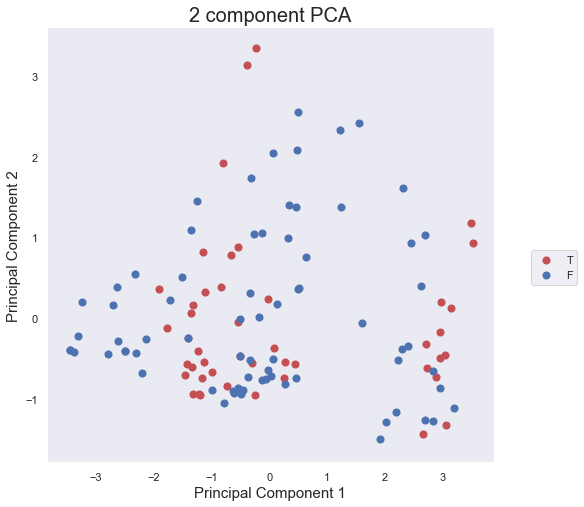

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, op[['label']]], axis = 1)
print(pca.components_)
print(pca.explained_variance_)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['T', 'F']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets, bbox_to_anchor=(1.2,0.5))
ax.grid()

In [40]:
noObser = op.loc[op['Observations'].isnull()]
haveObser = op.loc[op['Observations'].notnull()]
# haveObser.to_csv("haveObser.csv")
# noObser.to_csv("noObser.csv")

In [38]:
noObser.describe()

,S_peeps,S_hour,OPE,Rain,S_fuel,flights,Craugastoridae,Bufonidae,Plethodontidae,Hylidae,Leptodactylidae,Phyllomedusidae,Centrolenidae,Rhinathrematidae,Observations
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,98.777778,1239.680556,7.263889,1.375000,270.027778,8.847222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,51.006827,603.124256,4.660270,2.590978,293.401133,9.109134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,51.750000,810.000000,5.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,103.000000,1259.500000,6.000000,0.000000,162.500000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,124.250000,1450.000000,9.000000,1.500000,461.750000,15.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,204.000000,2390.000000,15.000000,10.000000,1400.000000,34.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
haveObser.describe()

,S_peeps,S_hour,OPE,Rain,S_fuel,flights,Craugastoridae,Bufonidae,Plethodontidae,Hylidae,Leptodactylidae,Phyllomedusidae,Centrolenidae,Rhinathrematidae,Observations
count,45.000000,45.000000,45.000000,45.000000,45.00000,45.000000,43.000000,41.000000,5.000000,17.000000,18.000000,5.000000,7.000000,2.0,45.000000
mean,113.244444,1350.911111,8.133333,1.542222,248.20000,8.733333,9.674419,3.707317,1.200000,2.235294,2.000000,1.200000,1.428571,1.0,14.800000
std,54.280482,590.158177,4.251203,2.757839,237.36399,9.208198,4.853673,2.812862,0.447214,1.393261,1.236694,0.447214,0.534522,0.0,7.313126
min,32.000000,750.000000,4.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,3.000000
25%,70.000000,920.000000,5.000000,0.000000,0.00000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,10.000000
50%,89.000000,1030.000000,6.000000,0.000000,192.00000,7.000000,9.000000,3.000000,1.000000,2.000000,1.500000,1.000000,1.000000,1.0,13.000000
75%,191.000000,2150.000000,14.000000,3.000000,442.00000,12.000000,12.500000,6.000000,1.000000,4.000000,2.750000,1.000000,2.000000,1.0,19.000000
max,214.000000,2390.000000,15.000000,11.000000,840.00000,39.000000,21.000000,11.000000,2.000000,5.000000,4.000000,2.000000,2.000000,1.0,30.000000
